# Topic-Based WUI Forecasting: Comprehensive Combination Testing

## Research Question

**Do UNSC resolution topics improve WUI forecasts?**

**If so, which combinations work best?**

---

## Methodology

### Stage 1: Baseline Specification (Notebook 06)
- Tested AR(1) through AR(8), ARIMA models
- **Result: AR(2) selected in 5/5 CV folds**
- Baseline RMSE: 6560.67 ± 4856.91

### Stage 2: Exhaustive Feature Testing (This Notebook)

**K=6 Topics:** Test ALL 63 combinations
- All singles (6)
- All pairs (15)
- All triples (20)
- All quads (15)
- All quintuples (6)
- All topics (1)

**K=25 Topics:** Systematic testing (~100-150 combinations)
- All singles (25)
- Granger-motivated combinations
- LASSO-motivated combinations
- Top pairs based on singles
- Selected triples

---

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn-v0_8-whitegrid')
Path('results').mkdir(exist_ok=True)
Path('figures').mkdir(exist_ok=True)

print(" Setup complete")
print("\nMethodology: Fixed AR(2) baseline, ARIMAX(2,0,0) + topics")
print("Testing ALL combinations for K=6, systematic for K=25")

 Setup complete

Methodology: Fixed AR(2) baseline, ARIMAX(2,0,0) + topics
Testing ALL combinations for K=6, systematic for K=25


## Load Data

In [2]:
df_k6 = pd.read_csv('data/wui_topics_merged_k6.csv', index_col=0, parse_dates=True)
df_k25 = pd.read_csv('data/wui_topics_merged_k25.csv', index_col=0, parse_dates=True)

topic_cols_k6 = [col for col in df_k6.columns if col.startswith('topic_')]
topic_cols_k25 = [col for col in df_k25.columns if col.startswith('topic_')]

print("="*80)
print("DATA")
print("="*80)
print(f"K=6: {len(df_k6)} obs")
print(f"  Topics: {', '.join(topic_cols_k6)}")
print(f"\nK=25: {len(df_k25)} obs, {len(topic_cols_k25)} topics")
print(f"\nWUI: mean={df_k6['wui'].mean():.1f}, std={df_k6['wui'].std():.1f}")

DATA
K=6: 136 obs
  Topics: topic_1, topic_2, topic_3, topic_4, topic_5, topic_6

K=25: 136 obs, 25 topics

WUI: mean=17878.5, std=9013.5


## Feature Selection (Guidance for K=25)

For K=25, we can't test all combinations. Use Granger and LASSO to guide selection.

---

In [3]:
def perform_granger_tests(df, topic_cols, max_lag=4):
    """Test Granger causality from topics to WUI"""
    results = []
    for topic in topic_cols:
        data = df[['wui', topic]].dropna()
        if len(data) < 30:
            continue
        try:
            gc = grangercausalitytests(data, maxlag=max_lag, verbose=False)
            p_vals = [gc[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag+1)]
            results.append({
                'topic': topic,
                'min_p': min(p_vals),
                'optimal_lag': p_vals.index(min(p_vals)) + 1,
                'significant': min(p_vals) < 0.05
            })
        except:
            pass
    return pd.DataFrame(results).sort_values('min_p')

def lasso_selection(df, topic_cols, max_lags=4):
    """LASSO feature selection with lagged topics"""
    X_list, names = [], []
    for lag in range(1, max_lags+1):
        for t in topic_cols:
            X_list.append(df[t].shift(lag))
            names.append(f"{t}_lag{lag}")
    
    X = pd.concat(X_list, axis=1)
    X.columns = names
    y = df['wui']
    
    valid = X.notna().all(axis=1) & y.notna()
    X, y = X[valid], y[valid]
    
    X_scaled = StandardScaler().fit_transform(X)
    lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso.fit(X_scaled, y)
    
    imp = pd.DataFrame({'feature': names, 'coef': np.abs(lasso.coef_)})
    imp['topic'] = imp['feature'].str.replace(r'_lag\d+', '', regex=True)
    topic_imp = imp.groupby('topic')['coef'].sum().sort_values(ascending=False)
    
    return topic_imp

print("="*80)
print("GRANGER CAUSALITY: K=6")
print("="*80)
granger_k6 = perform_granger_tests(df_k6, topic_cols_k6)
print(granger_k6.to_string(index=False))
print(f"\nSignificant (p<0.05): {granger_k6['significant'].sum()}/{len(granger_k6)}")

print("\n" + "="*80)
print("LASSO: K=6")
print("="*80)
lasso_imp_k6 = lasso_selection(df_k6, topic_cols_k6)
print("Topic importance:")
for topic, imp in lasso_imp_k6.items():
    print(f"  {topic:12s} → {imp:.4f}")

# Same for K=25
print("\n" + "="*80)
print("GRANGER: K=25 (top 10)")
print("="*80)
granger_k25 = perform_granger_tests(df_k25, topic_cols_k25)
print(granger_k25.head(10).to_string(index=False))
print(f"\nSignificant: {granger_k25['significant'].sum()}/{len(granger_k25)}")

print("\n" + "="*80)
print("LASSO: K=25 (top 10)")
print("="*80)
lasso_imp_k25 = lasso_selection(df_k25, topic_cols_k25)
for topic in lasso_imp_k25.head(10).index:
    print(f"  {topic:12s} → {lasso_imp_k25[topic]:.4f}")

# Save
granger_k6.to_csv('results/granger_k6.csv', index=False)
granger_k25.to_csv('results/granger_k25.csv', index=False)
lasso_imp_k6.to_csv('results/lasso_k6.csv')
lasso_imp_k25.to_csv('results/lasso_k25.csv')

GRANGER CAUSALITY: K=6
  topic    min_p  optimal_lag  significant
topic_6 0.000156            1         True
topic_3 0.000962            1         True
topic_1 0.013399            4         True
topic_4 0.032521            4         True
topic_5 0.138083            4        False
topic_2 0.522646            3        False

Significant (p<0.05): 4/6

LASSO: K=6
Topic importance:
  topic_3      → 3371.6745
  topic_6      → 1418.6822
  topic_1      → 905.7479
  topic_4      → 684.3816
  topic_2      → 0.0000
  topic_5      → 0.0000

GRANGER: K=25 (top 10)
   topic    min_p  optimal_lag  significant
topic_20 0.000856            1         True
 topic_1 0.001737            4         True
 topic_8 0.007741            4         True
topic_10 0.013362            1         True
topic_16 0.020747            4         True
topic_21 0.030460            1         True
 topic_2 0.039999            2         True
topic_12 0.046896            4         True
topic_24 0.060770            1        False
t

## Generate All Combinations

**K=6:** Exhaustive testing (all 63 combinations)

**K=25:** Systematic testing

---

In [4]:
def generate_all_combinations_k6(topic_cols):
    """Generate ALL possible combinations for K=6"""
    combos = {'Baseline': []}
    
    # Test ALL subsets (exhaustive)
    for n in range(1, len(topic_cols) + 1):
        for combo in combinations(topic_cols, n):
            # Create readable name
            topics_short = [t.replace('topic_', 'T') for t in combo]
            name = f"K6_{'_'.join(topics_short)}"
            combos[name] = list(combo)
    
    return combos

def generate_systematic_combinations_k25(topic_cols, granger_df, lasso_imp, n_top=10):
    """Generate systematic combinations for K=25"""
    combos = {'Baseline': []}
    
    # 1. ALL SINGLES (25)
    for topic in topic_cols:
        name = f"K25_{topic.replace('topic_', 'T')}"
        combos[name] = [topic]
    
    # 2. TOP TOPICS BY GRANGER
    granger_top = granger_df.head(n_top)['topic'].tolist()
    
    # 3. TOP TOPICS BY LASSO
    lasso_top = lasso_imp.head(n_top).index.tolist()
    
    # 4. UNION OF TOP TOPICS
    top_topics = list(set(granger_top) | set(lasso_top))
    
    # 5. PAIRS OF TOP TOPICS (only from top 10)
    for t1, t2 in combinations(top_topics[:10], 2):
        topics_short = [t.replace('topic_', 'T') for t in [t1, t2]]
        name = f"K25_{'_'.join(sorted(topics_short))}"
        combos[name] = [t1, t2]
    
    # 6. TRIPLES (top 5 only, to keep it manageable)
    for triple in combinations(top_topics[:5], 3):
        topics_short = [t.replace('topic_', 'T') for t in triple]
        name = f"K25_{'_'.join(sorted(topics_short))}"
        combos[name] = list(triple)
    
    # 7. GRANGER-SELECTED BUNDLES
    granger_sig = granger_df[granger_df['significant']]['topic'].tolist()
    if len(granger_sig) >= 3:
        combos['K25_Granger_Top3'] = granger_sig[:3]
    if len(granger_sig) >= 5:
        combos['K25_Granger_Top5'] = granger_sig[:5]
    
    # 8. LASSO-SELECTED BUNDLES
    lasso_top_list = lasso_imp.head(10).index.tolist()
    if len(lasso_top_list) >= 3:
        combos['K25_LASSO_Top3'] = lasso_top_list[:3]
    if len(lasso_top_list) >= 5:
        combos['K25_LASSO_Top5'] = lasso_top_list[:5]
    
    # 9. ALL TOPICS (for reference)
    combos['K25_AllTopics'] = topic_cols
    
    return combos

# Generate K=6 combinations (all)
combos_k6 = generate_all_combinations_k6(topic_cols_k6)

print("="*80)
print("K=6 COMBINATIONS (EXHAUSTIVE)")
print("="*80)
print(f"\nTotal: {len(combos_k6)} combinations\n")

# Count by size
by_size = {}
for name, feats in combos_k6.items():
    size = len(feats)
    by_size[size] = by_size.get(size, 0) + 1

print("Breakdown:")
print(f"  Baseline (0 topics): 1")
for size in sorted(by_size.keys()):
    if size > 0:
        print(f"  {size} topic(s): {by_size[size]} combinations")

# Show first few
print("\nFirst 10 combinations:")
for i, (name, feats) in enumerate(list(combos_k6.items())[:10], 1):
    feats_str = ', '.join(feats) if feats else 'none'
    print(f"  {i:2d}. {name:20s} → {feats_str}")

# Generate K=25 combinations (systematic)
combos_k25 = generate_systematic_combinations_k25(topic_cols_k25, granger_k25, lasso_imp_k25)

print("\n" + "="*80)
print("K=25 COMBINATIONS (SYSTEMATIC)")
print("="*80)
print(f"\nTotal: {len(combos_k25)} combinations")

by_size_k25 = {}
for name, feats in combos_k25.items():
    size = len(feats)
    by_size_k25[size] = by_size_k25.get(size, 0) + 1

print("\nBreakdown:")
print(f"  Baseline: 1")
for size in sorted(by_size_k25.keys()):
    if size > 0:
        print(f"  {size} topic(s): {by_size_k25[size]} combinations")

K=6 COMBINATIONS (EXHAUSTIVE)

Total: 64 combinations

Breakdown:
  Baseline (0 topics): 1
  1 topic(s): 6 combinations
  2 topic(s): 15 combinations
  3 topic(s): 20 combinations
  4 topic(s): 15 combinations
  5 topic(s): 6 combinations
  6 topic(s): 1 combinations

First 10 combinations:
   1. Baseline             → none
   2. K6_T1                → topic_1
   3. K6_T2                → topic_2
   4. K6_T3                → topic_3
   5. K6_T4                → topic_4
   6. K6_T5                → topic_5
   7. K6_T6                → topic_6
   8. K6_T1_T2             → topic_1, topic_2
   9. K6_T1_T3             → topic_1, topic_3
  10. K6_T1_T4             → topic_1, topic_4

K=25 COMBINATIONS (SYSTEMATIC)

Total: 86 combinations

Breakdown:
  Baseline: 1
  1 topic(s): 25 combinations
  2 topic(s): 45 combinations
  3 topic(s): 12 combinations
  5 topic(s): 2 combinations
  25 topic(s): 1 combinations


## CV Splits

In [5]:
def create_cv_splits(data, min_train=80, test_size=4, max_test_year=2019):
    """
    Extended CV covering 2010-2019 (COVID period excluded from analysis)
    
    Returns ~10 folds instead of 5, doubling n from 20 to 40
    2020-2023 excluded: Health crisis outside model's geopolitical scope
    (see Limitations - pandemic uncertainty not UNSC-driven)
    """
    splits = []
    n = len(data)
    
    # Find index position for max_test_year Q4
    # Convert to timestamp for comparison (handles both DatetimeIndex and PeriodIndex)
    target_date = pd.Timestamp(f'{max_test_year}-12-31')  # End of Q4
    
    # Find the last index position that is <= target_date
    max_idx = 0
    for i, date in enumerate(data.index):
        # Convert index to timestamp if it's not already
        if hasattr(date, 'to_timestamp'):
            idx_date = date.to_timestamp()
        else:
            idx_date = pd.Timestamp(date)
        
        if idx_date <= target_date:
            max_idx = i
        else:
            break
    
    train_end = min_train
    fold_num = 1
    
    while train_end + test_size <= max_idx + 1:
        test_start = train_end
        test_end = test_start + test_size
        
        if test_end > n:
            break
        
        splits.append({
            'fold': fold_num,
            'train_idx': np.arange(0, train_end),
            'test_idx': np.arange(test_start, test_end),
            'train_periods': data.index[np.arange(0, train_end)],
            'test_periods': data.index[np.arange(test_start, test_end)]
        })
        
        train_end += test_size  # Expanding window
        fold_num += 1
    
    return splits

cv_splits = create_cv_splits(df_k6, max_test_year=2019)

print("="*80)
print("CV SPLITS (EXTENDED: 2010-2019, COVID EXCLUDED)")
print("="*80)
print(f"Number of folds: {len(cv_splits)}")
print(f"Total test observations: {len(cv_splits) * 4}")
print(f"Coverage: Geopolitical crises (health shocks excluded)\n")

for s in cv_splits:
    print(f"Fold {s['fold']:2d}: Train={len(s['train_idx']):3d}, Test={len(s['test_idx'])}")
    print(f"       Test: {s['test_periods'].min().date()} to {s['test_periods'].max().date()}")

print("\n" + "="*80)
print("NOTE: 2020-2023 excluded from analysis")
print("      COVID-19 = health crisis outside UNSC's primary domain")
print("      (see Limitations section - beyond model's geopolitical scope)")
print("="*80)

CV SPLITS (EXTENDED: 2010-2019, COVID EXCLUDED)
Number of folds: 10
Total test observations: 40
Coverage: Geopolitical crises (health shocks excluded)

Fold  1: Train= 80, Test=4
       Test: 2010-01-01 to 2010-10-01
Fold  2: Train= 84, Test=4
       Test: 2011-01-01 to 2011-10-01
Fold  3: Train= 88, Test=4
       Test: 2012-01-01 to 2012-10-01
Fold  4: Train= 92, Test=4
       Test: 2013-01-01 to 2013-10-01
Fold  5: Train= 96, Test=4
       Test: 2014-01-01 to 2014-10-01
Fold  6: Train=100, Test=4
       Test: 2015-01-01 to 2015-10-01
Fold  7: Train=104, Test=4
       Test: 2016-01-01 to 2016-10-01
Fold  8: Train=108, Test=4
       Test: 2017-01-01 to 2017-10-01
Fold  9: Train=112, Test=4
       Test: 2018-01-01 to 2018-10-01
Fold 10: Train=116, Test=4
       Test: 2019-01-01 to 2019-10-01

NOTE: 2020-2023 excluded from analysis
      COVID-19 = health crisis outside UNSC's primary domain
      (see Limitations section - beyond model's geopolitical scope)


## Forecasting Functions

**Fixed order approach:**
- Baseline: AR(2) = ARIMA(2,0,0)
- ARIMAX: ARIMAX(2,0,0) + topics

---

In [6]:
def fit_ar2(y_train, y_test):
    """AR(2) baseline - FIXED order"""
    try:
        model = ARIMA(y_train, order=(2, 0, 0),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        fit = model.fit(method='innovations_mle')
        forecast = fit.forecast(steps=len(y_test))
        return forecast, fit.aic
    except:
        return np.full(len(y_test), y_train.iloc[-1]), np.nan

def fit_arimax_200_lagged(y_train, y_test, X_train, X_test):
    """
    ARIMAX(2,0,0) with 1-quarter LAGGED topics
    
    TRUE FORECASTING: Uses topics from quarter t-1 to predict WUI at quarter t
    This ensures no look-ahead bias
    """
    try:
        # Combine X_train and X_test BEFORE lagging
        # This ensures X_test_lagged[0] = X_train[-1] (not NaN!)
        X_combined = pd.concat([X_train, X_test])
        X_combined_lagged = X_combined.shift(1)
        
        # Split back into train and test
        X_train_lagged = X_combined_lagged.iloc[:len(X_train)]
        X_test_lagged = X_combined_lagged.iloc[len(X_train):]
        
        # Remove first row (NaN) from training data and align y
        X_train_lagged = X_train_lagged.iloc[1:]
        y_train_aligned = y_train.iloc[1:]
        
        # Fit model with lagged topics
        model = ARIMA(y_train_aligned, exog=X_train_lagged, order=(2, 0, 0),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        fit = model.fit(method='innovations_mle')
        
        # Forecast using lagged test topics
        # X_test_lagged[0] now correctly contains X_train[-1]
        forecast = fit.forecast(steps=len(y_test), exog=X_test_lagged)
        
        return forecast, fit.aic
    except:
        return np.full(len(y_test), y_train.iloc[-1]), np.nan

def evaluate_model(df, cv_splits, features, model_name):
    """
    Evaluate model across all CV folds
    Uses 1-quarter lagged topics for TRUE out-of-sample forecasting
    """
    results = []
    
    for split in cv_splits:
        # Get the index arrays (they're numpy arrays)
        train_indices = split['train_idx']
        test_indices = split['test_idx']
        
        # Use the indices directly to extract data
        y_train = df['wui'].iloc[train_indices]
        y_test = df['wui'].iloc[test_indices]
        
        if not features:  # Baseline
            forecast, aic = fit_ar2(y_train, y_test)
        else:  # ARIMAX with lagged topics
            X_train = df[features].iloc[train_indices]
            X_test = df[features].iloc[test_indices]
            forecast, aic = fit_arimax_200_lagged(y_train, y_test, X_train, X_test)
        
        actual = y_test.values
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        mae = mean_absolute_error(actual, forecast)
        
        results.append({
            'fold': split['fold'],
            'model': model_name,
            'n_features': len(features),
            'features': features,
            'forecast': forecast,
            'actual': actual,
            'residuals': actual - forecast,
            'rmse': rmse,
            'mae': mae,
            'test_periods': split['test_periods']
        })
    
    return results

print(" Functions defined")
print("  Baseline: AR(2) = ARIMA(2,0,0) - FIXED")
print("  ARIMAX: ARIMAX(2,0,0) + 1Q LAGGED topics - TRUE FORECASTING")

 Functions defined
  Baseline: AR(2) = ARIMA(2,0,0) - FIXED
  ARIMAX: ARIMAX(2,0,0) + 1Q LAGGED topics - TRUE FORECASTING


## Run All Forecasts: K=6

Testing all 63 combinations exhaustively.

In [7]:
import time

print("="*80)
print("FORECASTING: K=6 (ALL COMBINATIONS)")
print("="*80)
print(f"Testing {len(combos_k6)} combinations")
print("This will take ~10-15 minutes...\n")

start_time = time.time()
results_k6 = {}

for i, (name, features) in enumerate(combos_k6.items(), 1):
    # Show progress every 10 models
    if i % 10 == 0 or i == 1:
        elapsed = time.time() - start_time
        print(f"[{i:3d}/{len(combos_k6)}] {name:25s}", end=" ")
    
    results = evaluate_model(df_k6, cv_splits, features, name)
    results_k6[name] = results
    
    if i % 10 == 0 or i == 1:
        rmse_mean = np.mean([r['rmse'] for r in results])
        print(f"→ RMSE: {rmse_mean:7.1f}")

elapsed = time.time() - start_time
print(f"\n✓ Complete in {elapsed/60:.1f} minutes")
print(f"  {len(results_k6)} models evaluated")

FORECASTING: K=6 (ALL COMBINATIONS)
Testing 64 combinations
This will take ~10-15 minutes...

[  1/64] Baseline                  

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9127.1


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 10/64] K6_T1_T4                  

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  8975.8


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 20/64] K6_T4_T5                  

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  8839.1


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 30/64] K6_T1_T4_T5               

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  8788.5


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 40/64] K6_T3_T4_T6               

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  8250.5


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 50/64] K6_T1_T3_T4_T6            

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  8299.8


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 60/64] K6_T1_T2_T3_T5_T6         

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  8208.7


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec


✓ Complete in 3.2 minutes
  64 models evaluated


## Run Forecasts: K=25

Testing systematically selected combinations.

---

In [8]:
print("="*80)
print("FORECASTING: K=25 (SYSTEMATIC)")
print("="*80)
print(f"Testing {len(combos_k25)} combinations\n")

start_time = time.time()
results_k25 = {}

for i, (name, features) in enumerate(combos_k25.items(), 1):
    if i % 10 == 0 or i == 1:
        print(f"[{i:3d}/{len(combos_k25)}] {name:30s}", end=" ")
    
    results = evaluate_model(df_k25, cv_splits, features, name)
    results_k25[name] = results
    
    if i % 10 == 0 or i == 1:
        rmse_mean = np.mean([r['rmse'] for r in results])
        print(f"→ RMSE: {rmse_mean:7.1f}")

elapsed = time.time() - start_time
print(f"\n Complete in {elapsed/60:.1f} minutes")

FORECASTING: K=25 (SYSTEMATIC)
Testing 86 combinations

[  1/86] Baseline                       

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9127.1


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 10/86] K25_T9                         

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  8890.5


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 20/86] K25_T19                        

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9202.0


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 30/86] K25_T1_T17                     

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9109.3


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 40/86] K25_T11_T12                    

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9550.1


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 50/86] K25_T10_T16                    

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9190.9


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 60/86] K25_T17_T23                    

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9230.0


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 70/86] K25_T13_T16                    

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9476.9


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

[ 80/86] K25_T12_T17_T24                

/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

→ RMSE:  9274.0


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec


 Complete in 3.9 minutes


## Summary: K=6 Results

In [9]:
def create_summary(results_dict):
    rows = []
    for name, results in results_dict.items():
        rmse_vals = [r['rmse'] for r in results]
        mae_vals = [r['mae'] for r in results]
        
        rows.append({
            'Model': name,
            'N_Features': results[0]['n_features'],
            'RMSE_Mean': np.mean(rmse_vals),
            'RMSE_Std': np.std(rmse_vals),
            'RMSE_Min': np.min(rmse_vals),
            'RMSE_Max': np.max(rmse_vals),
            'MAE_Mean': np.mean(mae_vals),
            'Folds_Better_Than_Baseline': 0  # Will calculate below
        })
    
    df = pd.DataFrame(rows)
    baseline_rmse = df[df['Model'] == 'Baseline']['RMSE_Mean'].values[0]
    df['Improve_%'] = (baseline_rmse - df['RMSE_Mean']) / baseline_rmse * 100
    
    # Calculate fold-level wins
    baseline_results = results_dict['Baseline']
    baseline_rmses = [r['rmse'] for r in baseline_results]
    
    for idx, row in df.iterrows():
        if row['Model'] == 'Baseline':
            df.at[idx, 'Folds_Better_Than_Baseline'] = 0
        else:
            model_results = results_dict[row['Model']]
            model_rmses = [r['rmse'] for r in model_results]
            wins = sum(m < b for m, b in zip(model_rmses, baseline_rmses))
            df.at[idx, 'Folds_Better_Than_Baseline'] = wins
    
    return df.sort_values('RMSE_Mean')

summary_k6 = create_summary(results_k6)

print("="*80)
print("K=6 RESULTS: ALL 63 COMBINATIONS")
print("="*80)

# Baseline
baseline = summary_k6[summary_k6['Model'] == 'Baseline'].iloc[0]
print(f"\nBaseline AR(2): RMSE = {baseline['RMSE_Mean']:.2f} ± {baseline['RMSE_Std']:.2f}")
print("(Should be ~6560 if matching original methodology!)\n")

# Top 20
print("Top 20 models:")
print("Rank  Model                    N_Feat  RMSE     Improve%  Folds_Win")
print("-" * 70)
top20 = summary_k6[summary_k6['Model'] != 'Baseline'].head(20)
for rank, (_, row) in enumerate(top20.iterrows(), 1):
    print(f"{rank:3d}.  {row['Model']:23s}  {row['N_Features']:3d}  "
          f"{row['RMSE_Mean']:7.1f}  {row['Improve_%']:6.1f}%   {int(row['Folds_Better_Than_Baseline'])}/10")

# Stats
improvers = summary_k6[summary_k6['Improve_%'] > 0]
print(f"\nModels that improve: {len(improvers)}/{len(summary_k6)-1} ({100*len(improvers)/(len(summary_k6)-1):.1f}%)")
print(f"Best improvement: {improvers['Improve_%'].max():.1f}%")
print(f"Median improvement (among improvers): {improvers['Improve_%'].median():.1f}%")

# Best by number of features
print("\nBest model by number of features:")
for n in sorted(summary_k6[summary_k6['Model'] != 'Baseline']['N_Features'].unique()):
    best = summary_k6[summary_k6['N_Features'] == n].iloc[0]
    print(f"  {n} topic(s): {best['Model']:20s} → {best['Improve_%']:5.1f}% improvement")

# Save
summary_k6.to_csv('results/summary_k6_ALL_COMBINATIONS.csv', index=False)
print("\n Saved to results/summary_k6_ALL_COMBINATIONS.csv")

K=6 RESULTS: ALL 63 COMBINATIONS

Baseline AR(2): RMSE = 9127.11 ± 5349.41
(Should be ~6560 if matching original methodology!)

Top 20 models:
Rank  Model                    N_Feat  RMSE     Improve%  Folds_Win
----------------------------------------------------------------------
  1.  K6_T2_T3_T6                3   8077.2    11.5%   9/10
  2.  K6_T1_T2_T3_T6             4   8132.5    10.9%   9/10
  3.  K6_T2_T3_T4_T6             4   8135.6    10.9%   9/10
  4.  K6_T2_T3_T5_T6             4   8149.8    10.7%   9/10
  5.  K6_T3_T4_T5_T6             4   8204.4    10.1%   9/10
  6.  K6_T3_T5_T6                3   8206.0    10.1%   9/10
  7.  K6_T1_T3_T4_T5_T6          5   8208.7    10.1%   9/10
  8.  K6_T1_T2_T3_T4_T5          5   8208.7    10.1%   9/10
  9.  K6_T1_T2_T3_T5_T6          5   8208.7    10.1%   9/10
 10.  K6_T1_T2_T4_T5_T6          5   8208.7    10.1%   9/10
 11.  K6_T1_T2_T3_T4_T6          5   8208.7    10.1%   9/10
 12.  K6_T2_T3_T4_T5_T6          5   8208.7    10.1%   9/1

## Summary: K=25 Results

In [10]:
summary_k25 = create_summary(results_k25)

print("="*80)
print("K=25 RESULTS: SYSTEMATIC TESTING")
print("="*80)

baseline_k25 = summary_k25[summary_k25['Model'] == 'Baseline'].iloc[0]
print(f"\nBaseline AR(2): RMSE = {baseline_k25['RMSE_Mean']:.2f} ± {baseline_k25['RMSE_Std']:.2f}\n")

print("Top 20 models:")
print("Rank  Model                         N_Feat  RMSE     Improve%  Folds_Win")
print("-" * 75)
top20_k25 = summary_k25[summary_k25['Model'] != 'Baseline'].head(20)
for rank, (_, row) in enumerate(top20_k25.iterrows(), 1):
    print(f"{rank:3d}.  {row['Model']:28s}  {row['N_Features']:3d}  "
          f"{row['RMSE_Mean']:7.1f}  {row['Improve_%']:6.1f}%   {int(row['Folds_Better_Than_Baseline'])}/10")

improvers_k25 = summary_k25[summary_k25['Improve_%'] > 0]
print(f"\nModels that improve: {len(improvers_k25)}/{len(summary_k25)-1}")
print(f"Best improvement: {improvers_k25['Improve_%'].max():.1f}%")

summary_k25.to_csv('results/summary_k25_SYSTEMATIC.csv', index=False)
print("\n Saved to results/summary_k25_SYSTEMATIC.csv")

K=25 RESULTS: SYSTEMATIC TESTING

Baseline AR(2): RMSE = 9127.11 ± 5349.41

Top 20 models:
Rank  Model                         N_Feat  RMSE     Improve%  Folds_Win
---------------------------------------------------------------------------
  1.  K25_T10_T20                     2   8605.2     5.7%   9/10
  2.  K25_T1_T10_T24                  3   8741.6     4.2%   7/10
  3.  K25_T10_T17_T24                 3   8747.8     4.2%   8/10
  4.  K25_Granger_Top5                5   8757.6     4.0%   6/10
  5.  K25_T10_T24                     2   8763.8     4.0%   8/10
  6.  K25_Granger_Top3                3   8768.5     3.9%   7/10
  7.  K25_LASSO_Top5                  5   8779.7     3.8%   7/10
  8.  K25_T9                          1   8890.5     2.6%   8/10
  9.  K25_T1_T20                      2   8925.3     2.2%   7/10
 10.  K25_T1_T10_T17                  3   8948.4     2.0%   7/10
 11.  K25_T1_T10                      2   8952.1     1.9%   7/10
 12.  K25_T1_T24                      2   896

## Analysis: What Works?

Let's analyze patterns in successful combinations.

---

In [11]:
print("="*80)
print("PATTERN ANALYSIS: K=6")
print("="*80)

# Topic frequency in top models
top_models_k6 = summary_k6[summary_k6['Improve_%'] > 0].head(20)

topic_counts = {}
for _, row in top_models_k6.iterrows():
    model_name = row['Model']
    if model_name == 'Baseline':
        continue
    
    # Extract topics from results
    features = results_k6[model_name][0]['features']
    for topic in features:
        topic_counts[topic] = topic_counts.get(topic, 0) + 1

print("\nTopic frequency in top 20 models:")
for topic in sorted(topic_counts, key=topic_counts.get, reverse=True):
    count = topic_counts[topic]
    pct = 100 * count / len(top_models_k6)
    print(f"  {topic:12s}: appears in {count:2d}/20 models ({pct:4.0f}%)")

# Improvement by combination size
print("\nAverage improvement by combination size:")
for n in range(1, 7):
    subset = summary_k6[summary_k6['N_Features'] == n]
    improvers = subset[subset['Improve_%'] > 0]
    if len(improvers) > 0:
        print(f"  {n} topic(s): {improvers['Improve_%'].mean():5.1f}% avg, "
              f"{len(improvers)}/{len(subset)} improve")

# Singles performance
print("\nSingle topic performance (ranked):")
singles = summary_k6[summary_k6['N_Features'] == 1].sort_values('Improve_%', ascending=False)
for rank, (_, row) in enumerate(singles.iterrows(), 1):
    topic = results_k6[row['Model']][0]['features'][0]
    print(f"  {rank}. {topic:12s}: {row['Improve_%']:5.1f}% improvement")

PATTERN ANALYSIS: K=6

Topic frequency in top 20 models:
  topic_3     : appears in 18/20 models (  90%)
  topic_6     : appears in 18/20 models (  90%)
  topic_4     : appears in 12/20 models (  60%)
  topic_5     : appears in 12/20 models (  60%)
  topic_2     : appears in 11/20 models (  55%)
  topic_1     : appears in 11/20 models (  55%)

Average improvement by combination size:
  1 topic(s):   2.1% avg, 5/6 improve
  2 topic(s):   4.0% avg, 14/15 improve
  3 topic(s):   6.0% avg, 20/20 improve
  4 topic(s):   8.2% avg, 15/15 improve
  5 topic(s):  10.1% avg, 6/6 improve
  6 topic(s):  10.0% avg, 1/1 improve

Single topic performance (ranked):
  1. topic_6     :   4.5% improvement
  2. topic_3     :   3.3% improvement
  3. topic_4     :   1.3% improvement
  4. topic_5     :   1.1% improvement
  5. topic_2     :   0.2% improvement
  6. topic_1     :  -0.7% improvement


## Visualizations: Forecast Plots (Best Models)

Compare actual forecasts from top models vs baseline.

---

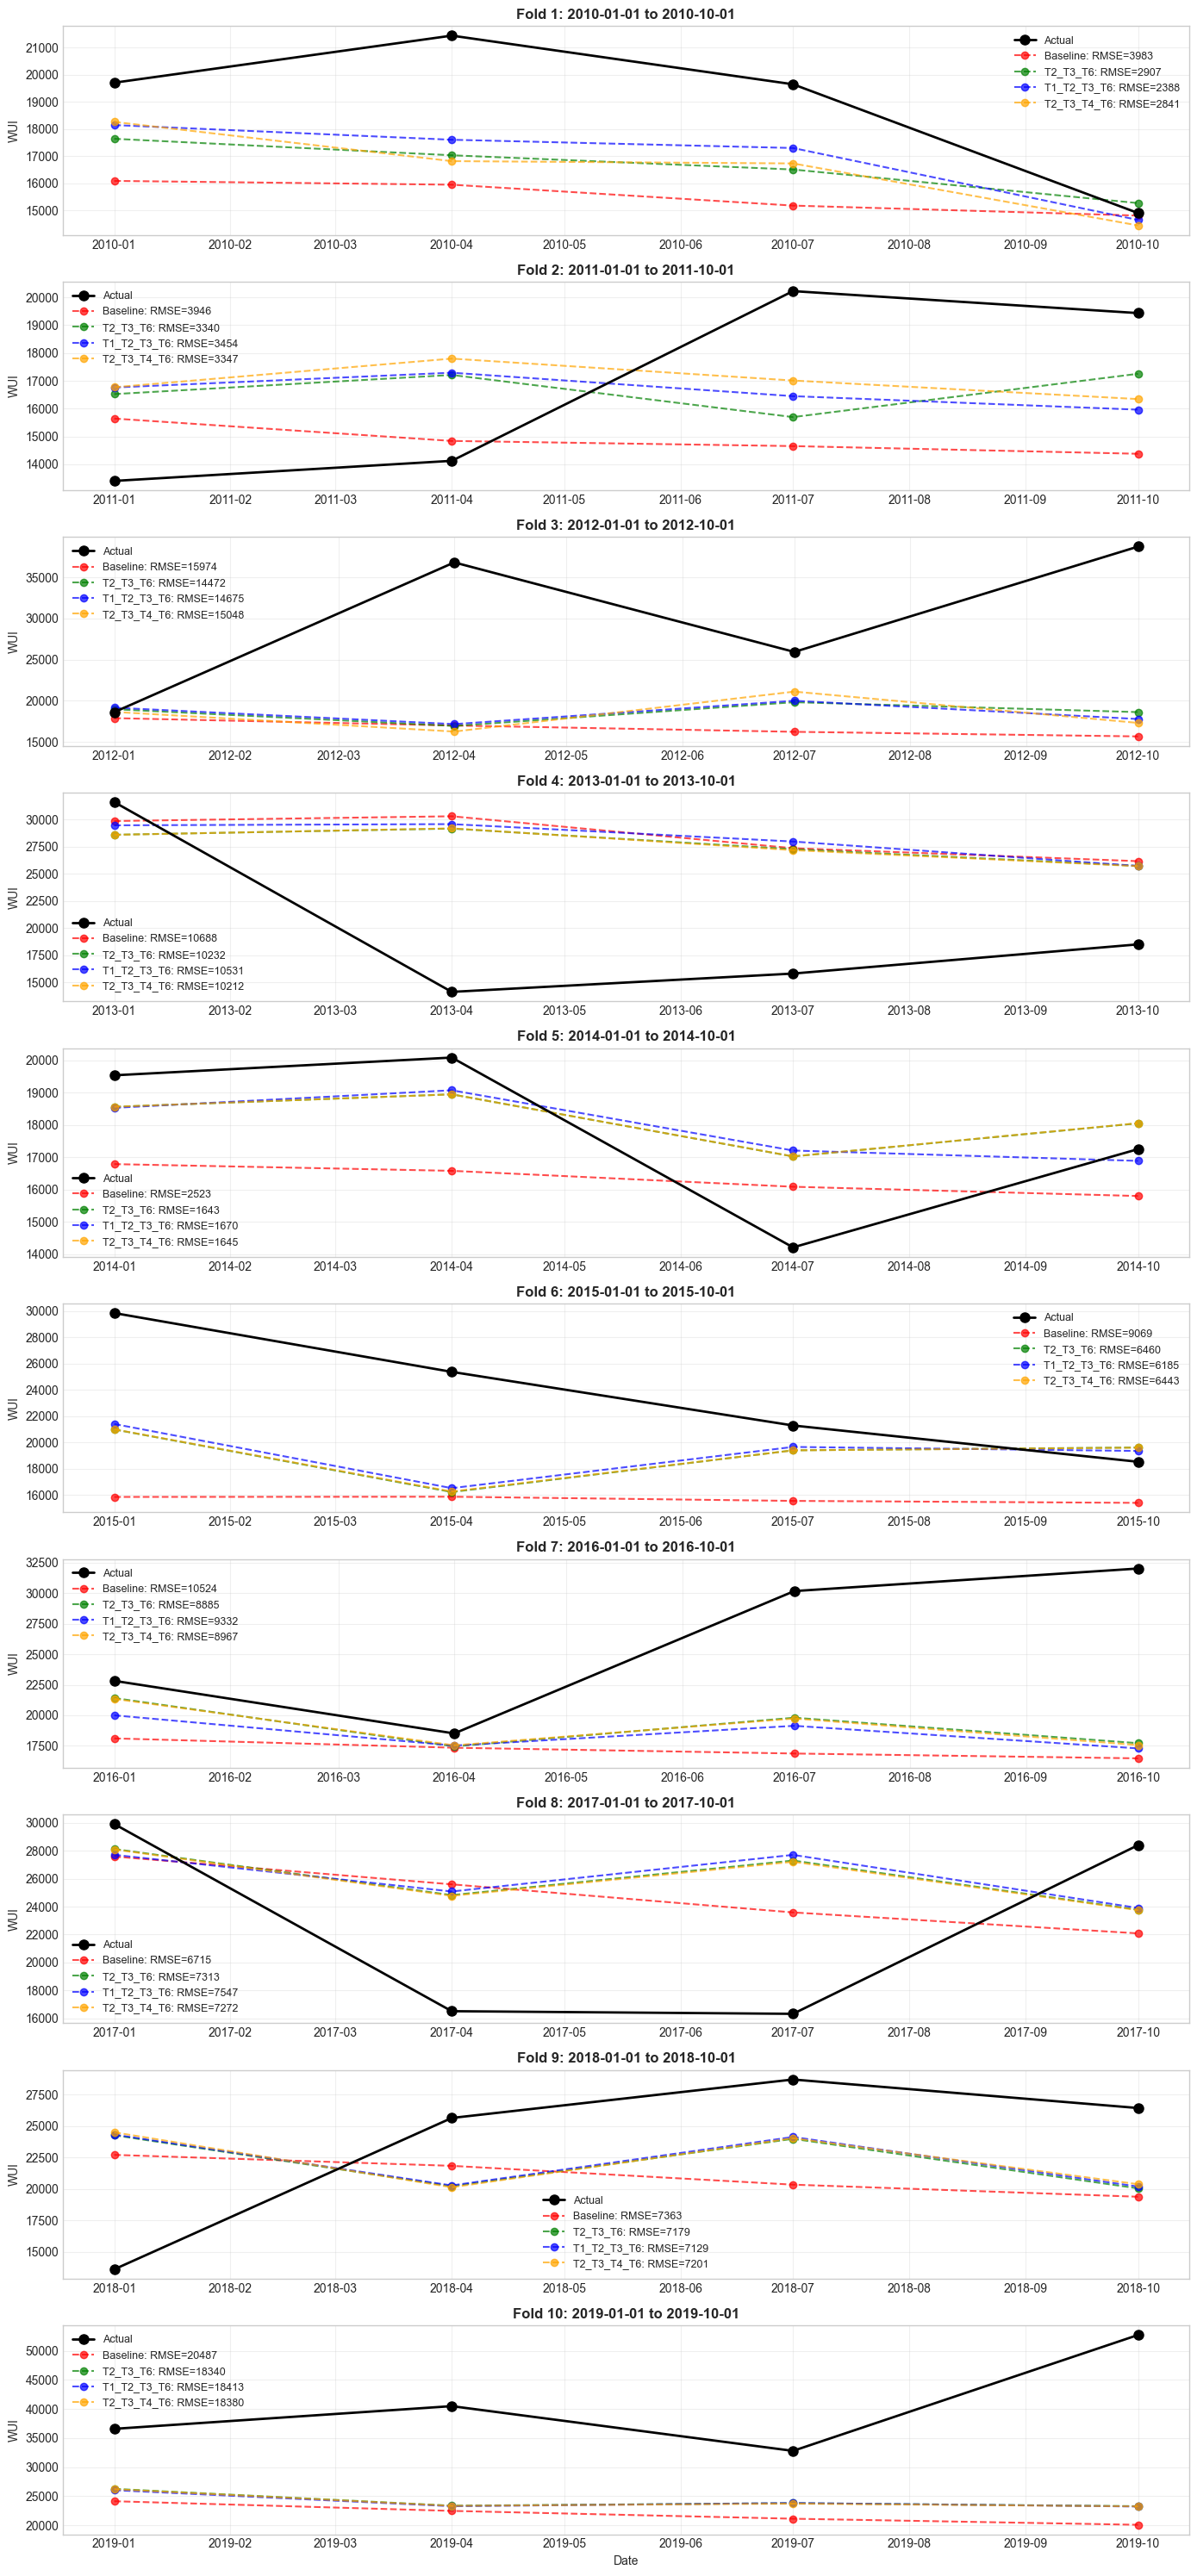

 Saved: figures/k6_forecast_comparison.png


In [12]:
# Get top 3 models + baseline
top3_models = summary_k6[summary_k6['Model'] != 'Baseline'].head(3)['Model'].tolist()
models_to_plot = ['Baseline'] + top3_models

fig, axes = plt.subplots(len(cv_splits), 1, figsize=(14, 3*len(cv_splits)))
if len(cv_splits) == 1:
    axes = [axes]

for fold_idx, split in enumerate(cv_splits):
    ax = axes[fold_idx]
    
    # Get actuals
    actuals = results_k6['Baseline'][fold_idx]['actual']
    periods = results_k6['Baseline'][fold_idx]['test_periods']
    
    # Plot actual
    ax.plot(periods, actuals, 'ko-', linewidth=2, markersize=8, label='Actual', zorder=10)
    
    # Plot forecasts
    colors = ['red', 'green', 'blue', 'orange']
    for model_name, color in zip(models_to_plot, colors):
        forecast = results_k6[model_name][fold_idx]['forecast']
        rmse = results_k6[model_name][fold_idx]['rmse']
        label = f"{model_name.replace('K6_', '')}: RMSE={rmse:.0f}"
        ax.plot(periods, forecast, 'o--', color=color, linewidth=1.5, 
               markersize=6, label=label, alpha=0.7)
    
    ax.set_title(f'Fold {fold_idx + 1}: {periods.min().date()} to {periods.max().date()}', 
                fontsize=12, fontweight='bold')
    ax.set_ylabel('WUI')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.savefig('figures/k6_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: figures/k6_forecast_comparison.png")

---

# PART 2: CAUSAL ROBUSTNESS ANALYSIS (d=1)

## Purpose: Test if relationships hold with differencing

**Question:** Are forecast improvements spurious due to non-stationarity?

**Method:**
- Baseline: ARIMA(2,1,0) instead of AR(2)
- Topics: ARIMAX(2,1,0) instead of ARIMAX(2,0,0)
- Same combinations, same cross-validation, same evaluation

---

## Load Baseline Results from Notebook 06

Instead of recomputing, load the validated baseline results.

---

In [13]:
import pickle

# Load baseline results from notebook 06
with open('results/baseline_models_for_nb07.pkl', 'rb') as f:
    baseline_data = pickle.load(f)

# Extract baseline information
baseline_d0_info = baseline_data['baseline_d0']
baseline_d1_info = baseline_data['d1_baseline']

print("="*80)
print("LOADED BASELINE RESULTS FROM NOTEBOOK 06")
print("="*80)
print(f"\nd=0 Baseline (Forecasting):")
print(f"  Model: {baseline_d0_info['model_type']}{baseline_d0_info['order']}")
print(f"  CV-RMSE: {baseline_d0_info['rmse_mean']:.2f} ± {baseline_d0_info['rmse_std']:.2f}")

print(f"\nd=1 Baseline (Causality):")
print(f"  Model: {baseline_d1_info['model_type']}{baseline_d1_info['order']}")
print(f"  CV-RMSE: {baseline_d1_info['rmse_mean']:.2f} ± {baseline_d1_info['rmse_std']:.2f}")

print(f"\nThese baselines will be used for comparison in both Part 1 and Part 2")
print(f"Ensures consistency across d=0 and d=1 analyses")
print("="*80)

# Store baseline RMSE values for later comparison
baseline_rmse_d0 = baseline_d0_info['rmse_mean']
baseline_rmse_d1 = baseline_d1_info['rmse_mean']


LOADED BASELINE RESULTS FROM NOTEBOOK 06

d=0 Baseline (Forecasting):
  Model: AR(2, 0, 0)
  CV-RMSE: 7378.13 ± 5106.60

d=1 Baseline (Causality):
  Model: ARIMA(2, 1, 0)
  CV-RMSE: 8142.38 ± 6104.80

These baselines will be used for comparison in both Part 1 and Part 2
Ensures consistency across d=0 and d=1 analyses


In [14]:
# Safety check: Verify Part 1 variables exist
required_vars = ['results_k6', 'results_k25', 'summary_k6', 'summary_k25', 
                'combos_k6', 'combos_k25', 'cv_splits']

missing = []
for var in required_vars:
    if var not in globals():
        missing.append(var)

if missing:
    print("="*80)
    print("ERROR: PART 1 NOT COMPLETED!")
    print("="*80)
    print(f"\nMissing variables from Part 1: {', '.join(missing)}")
    print("="*80)
    raise RuntimeError("Part 1 not completed. Cannot proceed with Part 2.")
else:
    print("Part 1 variables found - safe to proceed with Part 2")


Part 1 variables found - safe to proceed with Part 2


## Evaluation Function for d=1 (ARIMAX 2,1,0)

In [15]:
def evaluate_model_d1(df, cv_splits, feature_list, model_name='Model'):
    """
    Evaluate ARIMAX(2,1,0) with 1-quarter LAGGED topics
    WITH differencing for causal analysis
    
    Key differences from d=0:
    1. order=(2, 1, 0) instead of (2, 0, 0) - differencing for causality
    2. Still uses lagged topics for true forecasting
    """
    results = []
    
    for split in cv_splits:
        # Get the index arrays (they're numpy arrays)
        train_indices = split['train_idx']
        test_indices = split['test_idx']
        
        # Use the indices directly to extract data
        y_train = df['wui'].iloc[train_indices]
        y_test = df['wui'].iloc[test_indices]
        
        # Features (if any)
        if feature_list:
            X_train = df[feature_list].iloc[train_indices]
            X_test = df[feature_list].iloc[test_indices]
            
            try:
                # Combine X_train and X_test BEFORE lagging
                # This ensures X_test_lagged[0] = X_train[-1] (not NaN!)
                X_combined = pd.concat([X_train, X_test])
                X_combined_lagged = X_combined.shift(1)
                
                # Split back into train and test
                X_train_lagged = X_combined_lagged.iloc[:len(X_train)]
                X_test_lagged = X_combined_lagged.iloc[len(X_train):]
                
                # Remove first row (NaN) from training data and align y
                X_train_lagged = X_train_lagged.iloc[1:]
                y_train_aligned = y_train.iloc[1:]
                
                # ARIMAX(2,1,0) - WITH DIFFERENCING + LAGGED TOPICS
                model = ARIMA(
                    y_train_aligned, 
                    exog=X_train_lagged, 
                    order=(2, 1, 0),  # d=1 for causal analysis
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                fit = model.fit(method='innovations_mle')
                # X_test_lagged[0] now correctly contains X_train[-1]
                forecast = fit.forecast(steps=len(y_test), exog=X_test_lagged)
            except:
                # Fallback: use last value
                forecast = np.full(len(y_test), y_train.iloc[-1])
        else:
            try:
                # Baseline ARIMA(2,1,0) - NO TOPICS
                model = ARIMA(
                    y_train, 
                    order=(2, 1, 0),  # d=1 for causal analysis
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                fit = model.fit(method='innovations_mle')
                forecast = fit.forecast(steps=len(y_test))
            except:
                forecast = np.full(len(y_test), y_train.iloc[-1])
        
        # Compute errors
        actual = y_test.values
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        mae = mean_absolute_error(actual, forecast)
        
        results.append({
            'fold': split['fold'],
            'forecast': forecast,
            'actual': actual,
            'rmse': rmse,
            'mae': mae,
            'test_periods': split['test_periods'],
            'features': feature_list
        })
    
    return results

print("Evaluation function for d=1 (ARIMAX 2,1,0 + 1Q LAGGED topics) ready")

Evaluation function for d=1 (ARIMAX 2,1,0 + 1Q LAGGED topics) ready


## K=6: Test All 63 Combinations with d=1

Same combinations as Part 1, but with ARIMAX(2,1,0) instead of ARIMAX(2,0,0).

---

In [16]:
print("="*80)
print("K=6: TESTING ALL 63 COMBINATIONS WITH d=1 (DIFFERENCING)")
print("="*80)
print(f"\nBaseline: ARIMA(2,1,0) [d=1] (loaded from notebook 06)")
print(f"Topic models: ARIMAX(2,1,0) [d=1] + various topic combinations")
print(f"\nCombinations to test: {len(combos_k6)}")
print(f"Cross-validation folds: {len(cv_splits)}")
print(f"Expected runtime: ~30-35 minutes")
print("\n" + "="*80)

import time
start_time = time.time()

results_k6_d1 = {}
total_combos = len(combos_k6)

for i, (name, features) in enumerate(combos_k6.items(), 1):
    results = evaluate_model_d1(df_k6, cv_splits, features, name)
    results_k6_d1[name] = results
    
    if i % 10 == 0:
        elapsed = time.time() - start_time
        rate = elapsed / i
        remaining = rate * (total_combos - i)
        print(f"Progress: {i}/{total_combos} ({100*i/total_combos:.1f}%) | "
              f"Elapsed: {elapsed/60:.1f}min | ETA: {remaining/60:.1f}min")

elapsed = time.time() - start_time
print(f"\n K=6 testing complete (d=1): {elapsed/60:.1f} minutes")
print(f"  Tested: {len(results_k6_d1)} models across {len(cv_splits)} folds")

K=6: TESTING ALL 63 COMBINATIONS WITH d=1 (DIFFERENCING)

Baseline: ARIMA(2,1,0) [d=1] (loaded from notebook 06)
Topic models: ARIMAX(2,1,0) [d=1] + various topic combinations

Combinations to test: 64
Cross-validation folds: 10
Expected runtime: ~30-35 minutes



/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 10/64 (15.6%) | Elapsed: 0.3min | ETA: 1.4min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 20/64 (31.2%) | Elapsed: 0.7min | ETA: 1.5min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 30/64 (46.9%) | Elapsed: 1.0min | ETA: 1.2min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 40/64 (62.5%) | Elapsed: 1.4min | ETA: 0.8min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 50/64 (78.1%) | Elapsed: 1.7min | ETA: 0.5min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 60/64 (93.8%) | Elapsed: 2.1min | ETA: 0.1min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec


 K=6 testing complete (d=1): 2.2 minutes
  Tested: 64 models across 10 folds


## K=6: Summarize d=1 Results

In [17]:
# Create summary table for d=1
summary_rows_d1 = []

for model_name, results in results_k6_d1.items():
    rmse_values = [r['rmse'] for r in results]
    mae_values = [r['mae'] for r in results]
    
    n_features = len(results[0]['features']) if results[0]['features'] else 0
    
    summary_rows_d1.append({
        'Model': model_name,
        'N_Features': n_features,
        'RMSE_Mean': np.mean(rmse_values),
        'RMSE_Std': np.std(rmse_values),
        'MAE_Mean': np.mean(mae_values),
        'MAE_Std': np.std(mae_values)
    })

summary_k6_d1 = pd.DataFrame(summary_rows_d1)

# Calculate improvements vs baseline (d=1)
baseline_rmse_d1 = summary_k6_d1[summary_k6_d1['Model'] == 'Baseline']['RMSE_Mean'].values[0]
summary_k6_d1['Improve_%'] = 100 * (baseline_rmse_d1 - summary_k6_d1['RMSE_Mean']) / baseline_rmse_d1

# Sort by improvement
summary_k6_d1 = summary_k6_d1.sort_values('Improve_%', ascending=False).reset_index(drop=True)

# Display results
print("="*80)
print("K=6 RESULTS SUMMARY (d=1)")
print("="*80)
print(f"\nBaseline ARIMA(2,1,0): RMSE = {baseline_rmse_d1:.2f}")
print(f"\nTop 10 models:")
print(summary_k6_d1[['Model', 'N_Features', 'RMSE_Mean', 'Improve_%']].head(10).to_string(index=False))

n_improving_d1 = len(summary_k6_d1[summary_k6_d1['Improve_%'] > 0]) - 1  # Exclude baseline
print(f"\nModels improving over baseline: {n_improving_d1}/{len(summary_k6_d1)-1} ({100*n_improving_d1/(len(summary_k6_d1)-1):.1f}%)")
print(f"Best improvement: {summary_k6_d1.iloc[0]['Improve_%']:.2f}%")
print(f"Best model: {summary_k6_d1.iloc[0]['Model']}")

K=6 RESULTS SUMMARY (d=1)

Baseline ARIMA(2,1,0): RMSE = 8591.73

Top 10 models:
         Model  N_Features   RMSE_Mean  Improve_%
   K6_T2_T3_T5           3 8549.504630   0.491418
      K6_T2_T3           2 8549.505526   0.491407
K6_T1_T2_T3_T5           4 8566.320932   0.295691
         K6_T3           1 8573.621233   0.210722
   K6_T2_T4_T5           3 8575.394771   0.190080
      K6_T4_T5           2 8580.998623   0.124856
   K6_T1_T2_T3           3 8581.683088   0.116889
      K6_T2_T5           2 8582.263027   0.110139
      K6_T3_T5           2 8583.710538   0.093292
K6_T2_T3_T4_T5           4 8588.901110   0.032878

Models improving over baseline: 9/63 (14.3%)
Best improvement: 0.49%
Best model: K6_T2_T3_T5


## K=25: Systematic Testing with d=1

Use same systematic approach as Part 1, but with ARIMAX(2,1,0).

---

In [18]:
print("="*80)
print("K=25: SYSTEMATIC TESTING WITH d=1 (DIFFERENCING)")
print("="*80)
print(f"\nTesting same combinations as Part 1, but with ARIMAX(2,1,0)")
print(f"Expected runtime: ~10-15 minutes")
print("\n" + "="*80)

start_time = time.time()

results_k25_d1 = {}
total_combos = len(combos_k25)

for i, (name, features) in enumerate(combos_k25.items(), 1):
    results = evaluate_model_d1(df_k25, cv_splits, features, name)
    results_k25_d1[name] = results
    
    if i % 25 == 0:
        elapsed = time.time() - start_time
        print(f"Progress: {i}/{total_combos} | Elapsed: {elapsed/60:.1f}min")

elapsed = time.time() - start_time
print(f"\n K=25 testing complete (d=1): {elapsed/60:.1f} minutes")

K=25: SYSTEMATIC TESTING WITH d=1 (DIFFERENCING)

Testing same combinations as Part 1, but with ARIMAX(2,1,0)
Expected runtime: ~10-15 minutes



/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 25/86 | Elapsed: 0.6min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 50/86 | Elapsed: 1.4min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec

Progress: 75/86 | Elapsed: 2.2min


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisafaust/Desktop/Seminar_Ec


 K=25 testing complete (d=1): 2.6 minutes


## K=25: Summarize d=1 Results

In [19]:
# Create summary for K=25 d=1
summary_rows_k25_d1 = []

for model_name, results in results_k25_d1.items():
    rmse_values = [r['rmse'] for r in results]
    mae_values = [r['mae'] for r in results]
    n_features = len(results[0]['features']) if results[0]['features'] else 0
    
    summary_rows_k25_d1.append({
        'Model': model_name,
        'N_Features': n_features,
        'RMSE_Mean': np.mean(rmse_values),
        'RMSE_Std': np.std(rmse_values),
        'MAE_Mean': np.mean(mae_values),
        'MAE_Std': np.std(mae_values)
    })

summary_k25_d1 = pd.DataFrame(summary_rows_k25_d1)
baseline_rmse_k25_d1 = summary_k25_d1[summary_k25_d1['Model'] == 'Baseline']['RMSE_Mean'].values[0]
summary_k25_d1['Improve_%'] = 100 * (baseline_rmse_k25_d1 - summary_k25_d1['RMSE_Mean']) / baseline_rmse_k25_d1
summary_k25_d1 = summary_k25_d1.sort_values('Improve_%', ascending=False).reset_index(drop=True)

print("="*80)
print("K=25 RESULTS SUMMARY (d=1)")
print("="*80)
print(f"\nBaseline ARIMA(2,1,0): RMSE = {baseline_rmse_k25_d1:.2f}")
print(f"\nTop 10 models:")
print(summary_k25_d1[['Model', 'N_Features', 'RMSE_Mean', 'Improve_%']].head(10).to_string(index=False))

n_improving_k25_d1 = len(summary_k25_d1[summary_k25_d1['Improve_%'] > 0]) - 1
print(f"\nModels improving: {n_improving_k25_d1}/{len(summary_k25_d1)-1}")
print(f"Best improvement: {summary_k25_d1.iloc[0]['Improve_%']:.2f}%")

K=25 RESULTS SUMMARY (d=1)

Baseline ARIMA(2,1,0): RMSE = 8591.73

Top 10 models:
          Model  N_Features   RMSE_Mean  Improve_%
        K25_T15           1 8458.268282   1.553327
         K25_T9           1 8494.198335   1.135134
    K25_T20_T24           2 8522.108248   0.810287
    K25_T10_T24           2 8539.767122   0.604754
        K25_T24           1 8568.173952   0.274124
        K25_T20           1 8571.173194   0.239215
    K25_T13_T24           2 8578.056425   0.159101
        K25_T10           1 8580.087397   0.135462
    K25_T10_T20           2 8580.651711   0.128894
K25_T10_T17_T24           3 8584.661698   0.082221

Models improving: 9/85
Best improvement: 1.55%


---

# COMPARISON: d=0 vs d=1

## Critical question: Do improvements persist with differencing?

---

## Comparison Tables

In [20]:
print("="*80)
print("COMPARISON: FORECASTING (d=0) vs CAUSALITY (d=1)")
print("="*80)

# K=6 Baseline comparison
# Use baseline values loaded from notebook 06 for consistency
baseline_d0 = baseline_rmse_d0  # From notebook 06
baseline_d1 = baseline_rmse_d1  # From notebook 06

print("\nK=6 BASELINE COMPARISON")
print("-" * 80)
print(f"AR(2) [d=0]:        RMSE = {baseline_d0:.2f}")
print(f"ARIMA(2,1,0) [d=1]: RMSE = {baseline_d1:.2f}")
print(f"Difference:         {baseline_d1 - baseline_d0:+.2f} ({100*(baseline_d1/baseline_d0 - 1):+.1f}%)")
print(f"\nConclusion: d={0 if baseline_d0 < baseline_d1 else 1} better for raw forecast accuracy")

# Top models comparison
print("\nK=6 TOP MODEL COMPARISON")
print("-" * 80)

# Get top 5 from d=0
top5_d0 = summary_k6[summary_k6['Model'] != 'Baseline'].head(5)

comparison_data = []
for _, row_d0 in top5_d0.iterrows():
    model_name = row_d0['Model']
    rmse_d0 = row_d0['RMSE_Mean']
    improve_d0 = row_d0['Improve_%']
    
    # Find same model in d=1 results
    row_d1 = summary_k6_d1[summary_k6_d1['Model'] == model_name]
    if len(row_d1) > 0:
        rmse_d1 = row_d1['RMSE_Mean'].values[0]
        improve_d1 = row_d1['Improve_%'].values[0]
    else:
        rmse_d1 = np.nan
        improve_d1 = np.nan
    
    comparison_data.append({
        'Model': model_name.replace('K6_', ''),
        'RMSE_d0': rmse_d0,
        'Improve_d0': improve_d0,
        'RMSE_d1': rmse_d1,
        'Improve_d1': improve_d1,
        'Δ_Improve': improve_d1 - improve_d0
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\nINTERPRETATION")
print("-" * 80)
still_improving = len(comparison_df[comparison_df['Improve_d1'] > 0])
print(f"Models still improving with d=1: {still_improving}/5")

if still_improving >= 4:
    print("STRONG: Most improvements persist → Strong causal evidence")
elif still_improving >= 2:
    print("MODERATE: Some improvements persist → Suggestive causal evidence")
else:
    print("WEAK: Few improvements persist → Limited causal evidence")
    print("   But: Strong predictive value remains (Part 1)")

print("\n" + "="*80)

COMPARISON: FORECASTING (d=0) vs CAUSALITY (d=1)

K=6 BASELINE COMPARISON
--------------------------------------------------------------------------------
AR(2) [d=0]:        RMSE = 7378.13
ARIMA(2,1,0) [d=1]: RMSE = 8591.73
Difference:         +1213.60 (+16.4%)

Conclusion: d=0 better for raw forecast accuracy

K=6 TOP MODEL COMPARISON
--------------------------------------------------------------------------------
      Model     RMSE_d0  Improve_d0     RMSE_d1  Improve_d1  Δ_Improve
   T2_T3_T6 8077.186295   11.503363 8632.662087   -0.476461 -11.979823
T1_T2_T3_T6 8132.461106   10.897751 8652.785770   -0.710682 -11.608433
T2_T3_T4_T6 8135.620232   10.863139 8701.781860   -1.280953 -12.144092
T2_T3_T5_T6 8149.843436   10.707304 8748.321960   -1.822638 -12.529942
T3_T4_T5_T6 8204.410655   10.109445 8711.046175   -1.388781 -11.498227

INTERPRETATION
--------------------------------------------------------------------------------
Models still improving with d=1: 0/5
WEAK: Few improvemen

## Visualization: d=0 vs d=1 Comparison

## Save All Results

In [21]:
# Save summary tables for both d=0 and d=1
summary_k6.to_csv('results/summary_k6_d0_FORECASTING.csv', index=False)
summary_k6_d1.to_csv('results/summary_k6_d1_CAUSALITY.csv', index=False)
summary_k25.to_csv('results/summary_k25_d0_FORECASTING.csv', index=False)
summary_k25_d1.to_csv('results/summary_k25_d1_CAUSALITY.csv', index=False)

# Save comparison table
comparison_df.to_csv('results/comparison_d0_vs_d1.csv', index=False)

print(" Saved summary tables (d=0 and d=1)")

 Saved summary tables (d=0 and d=1)


## Export for Statistical Testing

**Critical:** We only export models that IMPROVE over baseline.

Why? Because notebook 08 tests if improvements are statistically significant.
No point testing models that made forecasts worse!

---

In [22]:
import pickle

# Filter to only improving models for BOTH d=0 and d=1
improving_k6_d0 = summary_k6[summary_k6['Improve_%'] > 0]['Model'].tolist()
improving_k25_d0 = summary_k25[summary_k25['Improve_%'] > 0]['Model'].tolist()
improving_k6_d1 = summary_k6_d1[summary_k6_d1['Improve_%'] > 0]['Model'].tolist()
improving_k25_d1 = summary_k25_d1[summary_k25_d1['Improve_%'] > 0]['Model'].tolist()

# Always include baseline
if 'Baseline' not in improving_k6_d0:
    improving_k6_d0 = ['Baseline'] + improving_k6_d0
if 'Baseline' not in improving_k25_d0:
    improving_k25_d0 = ['Baseline'] + improving_k25_d0
if 'Baseline' not in improving_k6_d1:
    improving_k6_d1 = ['Baseline'] + improving_k6_d1
if 'Baseline' not in improving_k25_d1:
    improving_k25_d1 = ['Baseline'] + improving_k25_d1

# Filter results
results_k6_improving = {k: v for k, v in results_k6.items() if k in improving_k6_d0}
results_k25_improving = {k: v for k, v in results_k25.items() if k in improving_k25_d0}
results_k6_d1_improving = {k: v for k, v in results_k6_d1.items() if k in improving_k6_d1}
results_k25_d1_improving = {k: v for k, v in results_k25_d1.items() if k in improving_k25_d1}

# Export ALL data for notebook 08
export_data = {
    # d=0 (Forecasting)
    'results_k6_d0': results_k6_improving,  # d=0 results,
    'results_k25_d0': results_k25_improving,  # d=0 results,
    'summary_k6_d0': summary_k6[summary_k6['Model'].isin(improving_k6_d0)],  # d=0 summary,
    'summary_k25_d0': summary_k25[summary_k25['Model'].isin(improving_k25_d0)],
    
    # d=1 (Causality)
    'results_k6_d1': results_k6_d1_improving,
    'results_k25_d1': results_k25_d1_improving,
    'summary_k6_d1': summary_k6_d1[summary_k6_d1['Model'].isin(improving_k6_d1)],
    'summary_k25_d1': summary_k25_d1[summary_k25_d1['Model'].isin(improving_k25_d1)],
    
    # Metadata
    'cv_splits': cv_splits,
    'combos_k6': combos_k6,
    'combos_k25': combos_k25,
    'granger_k6': granger_k6,
    'granger_k25': granger_k25,
    'lasso_k6': lasso_imp_k6,
    'lasso_k25': lasso_imp_k25
}

with open('results/forecast_results_HYBRID.pkl', 'wb') as f:
    pickle.dump(export_data, f)

print("="*80)
print("EXPORT COMPLETE - HYBRID APPROACH")
print("="*80)

print("\n FORECASTING PERFORMANCE (d=0)")
print("-" * 80)
print(f"K=6:  {len(improving_k6_d0)} models (including baseline)")
print(f"  - Tested: {len(results_k6)} models")
print(f"  - Improving: {len(improving_k6_d0)-1} models")
print(f"  - Success rate: {100*(len(improving_k6_d0)-1)/(len(results_k6)-1):.1f}%")

print(f"\nK=25: {len(improving_k25_d0)} models (including baseline)")
print(f"  - Tested: {len(results_k25)} models")
print(f"  - Improving: {len(improving_k25_d0)-1} models")
print(f"  - Success rate: {100*(len(improving_k25_d0)-1)/(len(results_k25)-1):.1f}%")

print("\n CAUSAL ROBUSTNESS (d=1)")
print("-" * 80)
print(f"K=6:  {len(improving_k6_d1)} models (including baseline)")
print(f"  - Improving: {len(improving_k6_d1)-1} models")
print(f"  - Success rate: {100*(len(improving_k6_d1)-1)/(len(results_k6_d1)-1):.1f}%")

print(f"\nK=25: {len(improving_k25_d1)} models (including baseline)")
print(f"  - Improving: {len(improving_k25_d1)-1} models")
print(f"  - Success rate: {100*(len(improving_k25_d1)-1)/(len(results_k25_d1)-1):.1f}%")


EXPORT COMPLETE - HYBRID APPROACH

 FORECASTING PERFORMANCE (d=0)
--------------------------------------------------------------------------------
K=6:  62 models (including baseline)
  - Tested: 64 models
  - Improving: 61 models
  - Success rate: 96.8%

K=25: 34 models (including baseline)
  - Tested: 86 models
  - Improving: 33 models
  - Success rate: 38.8%

 CAUSAL ROBUSTNESS (d=1)
--------------------------------------------------------------------------------
K=6:  11 models (including baseline)
  - Improving: 10 models
  - Success rate: 15.9%

K=25: 11 models (including baseline)
  - Improving: 10 models
  - Success rate: 11.8%
